# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [58]:
!pip install https://github.com/ydataai/pandas-profiling/archive/master.zip
!pip install catboost

In [59]:
!conda install --yes -c conda-forge lightgbm
!conda install --yes -c conda-forge xgboost

In [60]:
import ydata_profiling
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [61]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
df.head()

In [62]:
#использую профайлер для быстрой ориентировки в данных
df.profile_report()

Удалю дубликаты. 
Пропуски – в VehicleType (10.6%) – C, 
Gearbox (5.6%) – C, 
Model (5.6%) – C, 
FuelType (9.3%) – C, 
Repaired (20.1%) – Boolean.

Колонки DateCrawled, PostalCode, LastSeen и DateCreated никак не влияют на автомобиль, их стоит удалить. 

In [63]:
df = df.drop_duplicates()
df = df.drop(['DateCrawled', 'PostalCode', 'LastSeen', 'DateCreated'], axis=1)
df.info()

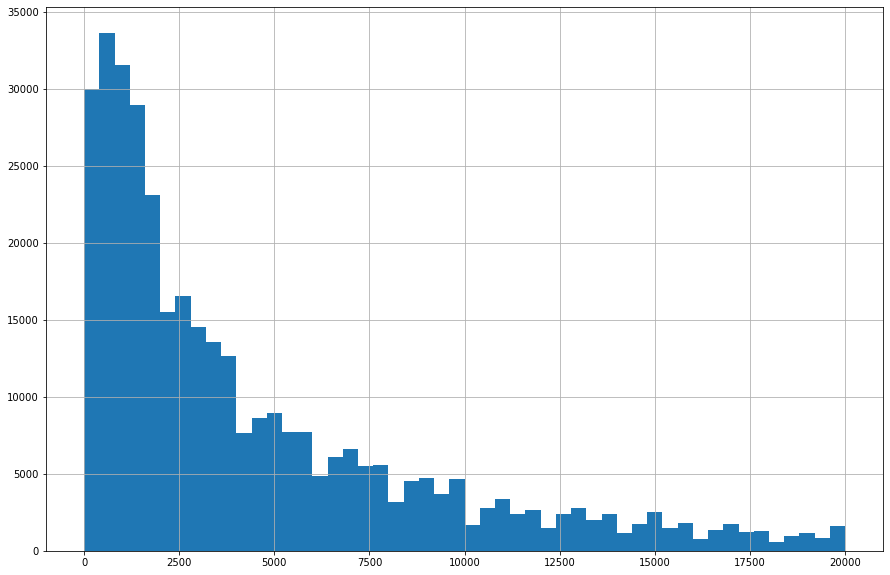

In [64]:
df['Price'].hist(bins=50, figsize=(15,10))
display(df[df['Price'] < 500]['Price'].count() / df['Price'].count() * 100)

0 в целевом признаке не нужны, сбросим
кроме того, машины меньше 500 евро – очевидно, ошибка заполнения данных. тем не менее, так как целевой признак менять нет оснований, лучше сбросить их для увеличения качества данных. Их около 10%.

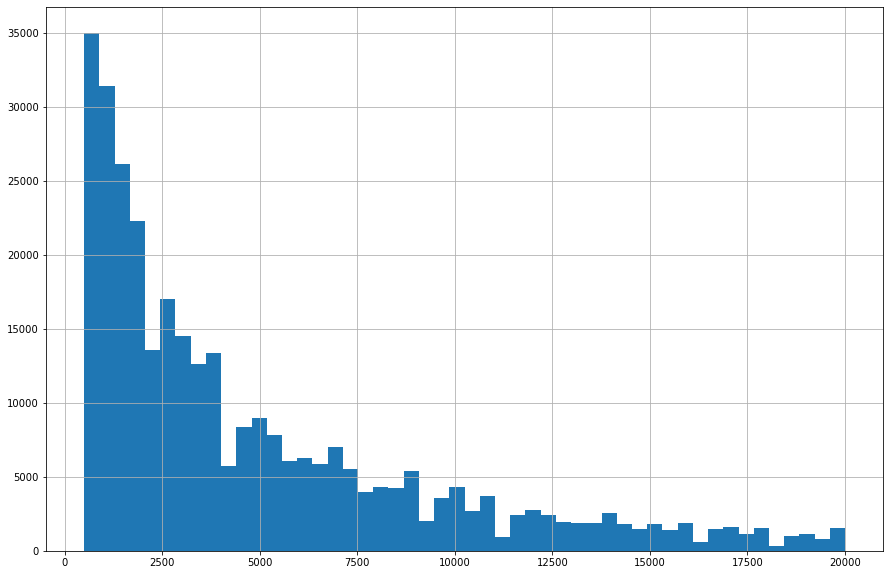

In [65]:
ind = df[df['Price'] < 500].index
df = df.drop(ind)
df['Price'].hist(bins=50, figsize=(15,10))

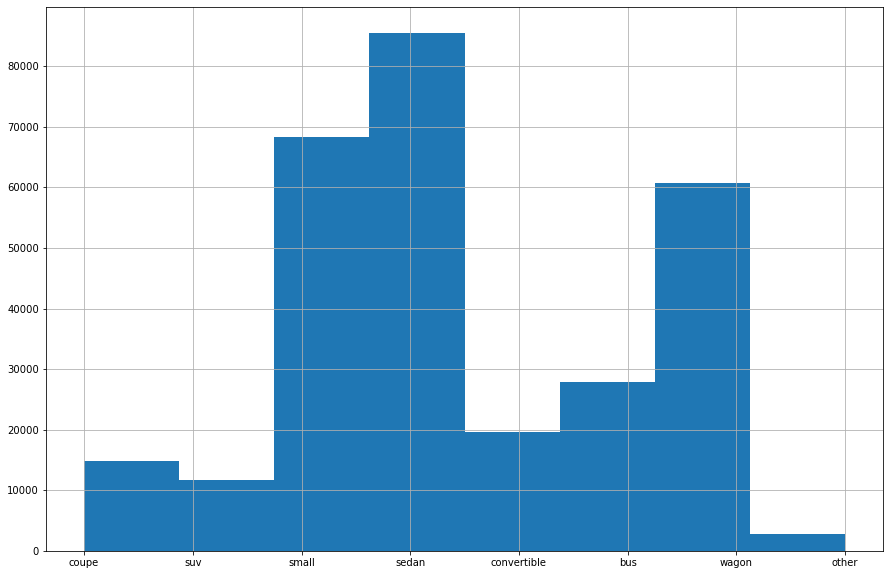

In [66]:
df[df['VehicleType'].notna()]['VehicleType'].hist(figsize=(15,10), bins=8)

In [67]:
df['VehicleType'].mode()

In [68]:
df.loc[df['VehicleType'].isna(), 'VehicleType'] = 'sedan'
df['VehicleType'].isna().sum()

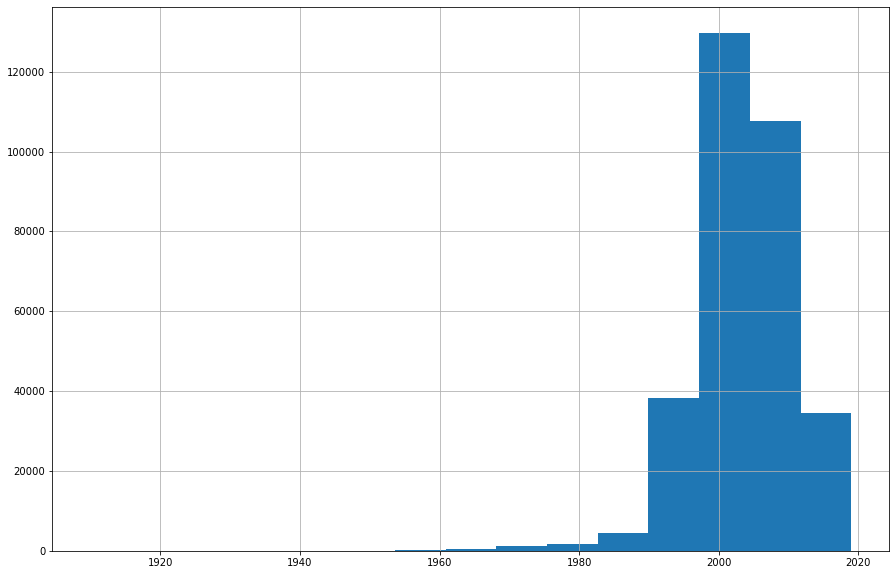

In [69]:
df.loc[(df['RegistrationYear'] < 2023) & 
       (df['RegistrationYear'] > 1900), 'RegistrationYear'].hist(bins=15, 
                                                                 figsize=(15,10))

In [70]:
display(df.loc[df['RegistrationYear'] < 1910, 'RegistrationYear'].count())
low_years = df.loc[df['RegistrationYear'] < 1910]
high_years =  df.loc[df['RegistrationYear'] > 2023]

In [71]:
df = df.drop(index=low_years.index)
df = df.drop(index=high_years.index)

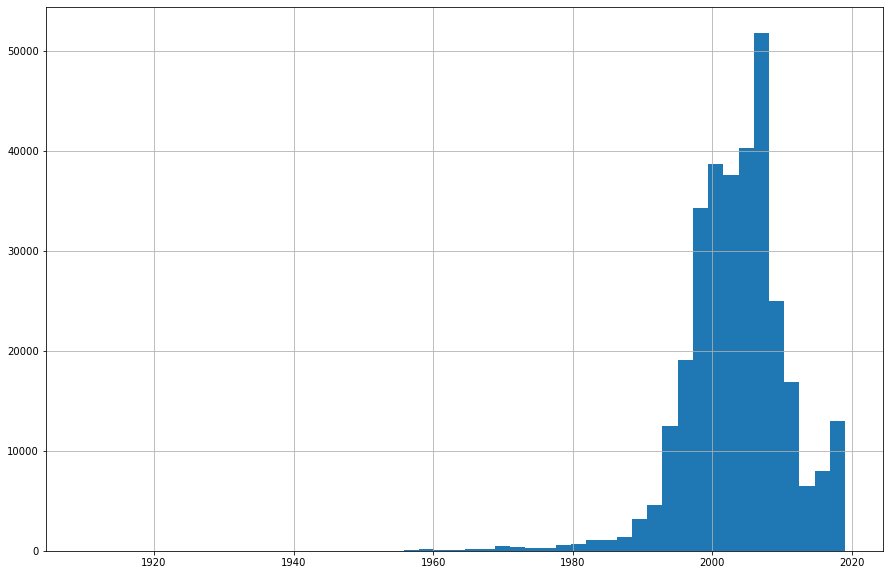

In [72]:
df['RegistrationYear'].hist(figsize=(15,10), bins=50)

In [73]:
df.loc[df['Gearbox'].isna(), 'Gearbox'] = 'manual'

df['Gearbox'].isna().sum()

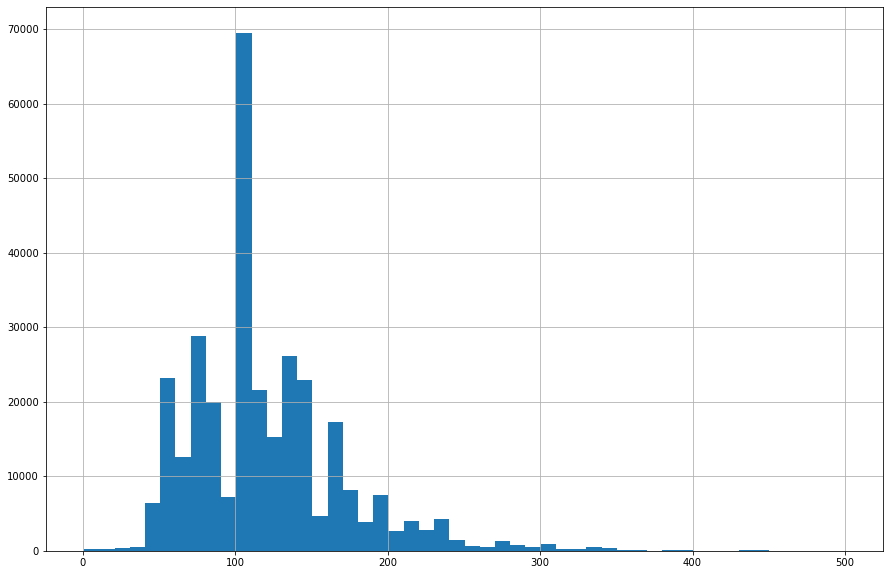

In [74]:
df.loc[df['Power'] > 500, 'Power'] = df['Power'].median()
df.loc[df['Power'] == 0, 'Power'] = df['Power'].median()
df['Power'].hist(bins=50, figsize=(15,10))

In [75]:
no_models = df.loc[df['Model'].isna()]
df = df.drop(index=no_models.index)

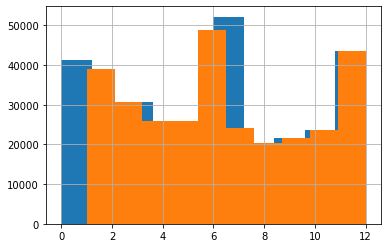

In [76]:
df.loc[df['RegistrationMonth'] < 13, 'RegistrationMonth'].hist()
df.loc[df['RegistrationMonth'] > 13, 'RegistrationMonth'] = df['RegistrationMonth'].median()
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = df['RegistrationMonth'].median()
df['RegistrationMonth'].hist()

In [77]:
no_fuel = df.loc[df['FuelType'].isna()]
df = df.drop(index = no_fuel.index)

In [78]:
df.loc[df['Repaired'].isna(), 'Repaired'] = 'unknown'

In [79]:
#df.profile_report()

In [80]:
df.info()

In [81]:
RS = np.random.RandomState(12345)

In [82]:
features = df.drop(['Price'], axis=1)
target = df['Price']
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=RS)

In [83]:
numeric = features_train.select_dtypes(exclude='object').columns.to_list()
numeric

In [84]:
categorical = features_train.select_dtypes(include='object').columns.to_list()
categorical

In [85]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train, 
                                                                            target_train, 
                                                                            test_size=0.25, 
                                                                            random_state=RS)

In [86]:
enc = OrdinalEncoder()
features_train_ordenc = features_train.copy()
features_train_ordenc[categorical] = enc.fit_transform(features_train[categorical])
display(features_train.shape, features_train_ordenc.shape)

In [87]:
scaler_ordenc = StandardScaler()
features_train_ordenc[numeric] = scaler_ordenc.fit_transform(features_train_ordenc[numeric])

In [88]:
features_train

In [89]:
ohe_enc = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
features_train_ohe = features_train.copy()
ohe_enc.fit(features_train_ohe[categorical])
features_train_ohe[ohe_enc.get_feature_names_out()] = ohe_enc.transform(features_train_ohe[categorical])
features_train_ohe = features_train_ohe.drop(categorical, axis=1)

In [90]:
scaler_ohe = StandardScaler()
features_train_ohe[numeric] = scaler_ohe.fit_transform(features_train_ohe[numeric])
features_train_ohe

Данные обработаны, первично дубликаты удалены, пропуски заполнены или удалены. Переменные, не относящиеся к анализу, удалены. Данные нормализованы.

## Обучение моделей

In [91]:
model_ridge = Ridge(random_state=RS)
param_grid_ridge = {
    'alpha': np.arange(0.01, 1.0, 0.01),
}

grid_ridge = RandomizedSearchCV(
    model_ridge,
    param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

grid_ridge.fit(features_train_ohe, target_train)

display(f'best_score: {grid_ridge.best_score_ * -1}')
display(f'best_params: {grid_ridge.best_params_}')

In [92]:
grid_ridge.cv_results_

In [93]:
model_cat_df = CatBoostRegressor()
param_grid_cat_1 = {
    
    'iterations': range(50, 200, 50),
    'learning_rate': np.arange(0.01, 0.1, 0.05),
    'depth': range(2, 9, 1),
    'l2_leaf_reg': (0.05, 3, 0.05)

}
grid_cat_1 = RandomizedSearchCV(
    model_cat_df,
    param_grid_cat_1,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

grid_cat_1.fit(features_train_ordenc, target_train)

display(f'best_score: {grid_cat_1.best_score_ * -1}')
display(f'best_params: {grid_cat_1.best_params_}')

In [94]:
results_cat_1 = pd.DataFrame(grid_cat_1.cv_results_)
display(results_cat_1.sort_values(by='rank_test_score').head(5))
results_cat_1['mean_fit_time'][3]

In [95]:
features_train.info()

In [96]:
cat_features = [0, 2, 4, 7, 8, 9]

model_cat_2 = CatBoostRegressor(cat_features=cat_features)
param_grid_cat_2 = {
    
    'iterations': range(100, 200, 50),
    'learning_rate': np.arange(0.01, 0.1, 0.05),
    'depth': range(2, 9, 1),
    'l2_leaf_reg': (0.1, 3, 0.05)

}
grid_cat_2 = RandomizedSearchCV(
    model_cat_2,
    param_grid_cat_2,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=False
)

grid_cat_2.fit(features_train, target_train)

display(f'best_score: {grid_cat_2.best_score_ * -1}')
display(f'best_params: {grid_cat_2.best_params_}')

In [97]:
results_cat_2 = pd.DataFrame(grid_cat_2.cv_results_)
display(results_cat_2.sort_values(by='rank_test_score').head(5))
results_cat_2['mean_fit_time'][8]

In [98]:
model_lgbm = LGBMRegressor()
params_lgbm = {'learning_rate': np.arange(0.03, 0.1),
               'n_estimators': range(200, 300),
               'num_leaves': range(100, 250),
               'max_depth': range(2,10)}

grid_lgbm = RandomizedSearchCV(
    model_lgbm,
    params_lgbm,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

grid_lgbm.fit(features_train_ordenc, target_train)
display(f'best_score: {grid_lgbm.best_score_ * -1}')
display(f'best_params: {grid_lgbm.best_params_}')

In [99]:
results_lgbm = pd.DataFrame(grid_lgbm.cv_results_)
display(results_lgbm.sort_values(by='rank_test_score').head(5))
results_lgbm['mean_fit_time'][6]

In [100]:
model_xgb = XGBRegressor()

params_xgb = {'learning_rate': np.arange(0.03, 0.1),
               'n_estimators': range(200, 300),
               'num_leaves': range(100, 250),
               'max_depth': range(2,10)}

grid_xgb = RandomizedSearchCV(
    model_xgb,
    params_xgb,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

grid_xgb.fit(features_train_ordenc, target_train)
display(f'best_score: {grid_xgb.best_score_ * -1}')
display(f'best_params: {grid_xgb.best_params_}')

In [101]:
results_xgb = pd.DataFrame(grid_xgb.cv_results_)
display(results_xgb.sort_values(by='rank_test_score').head(5))
results_xgb['mean_fit_time'][3]

Все модели кроме простой линейной регрессии справились по итогу обучения лучше обозначенного порога. 

## Анализ моделей

In [102]:
contest_table = pd.DataFrame({'Модель': {0:'CatBoost_prepoc', 1:'Catboost_cat', 2:'LGBMR', 3:'XGBR'}, 
                             'Результат обучения': {0:-grid_cat_1.best_score_, 1:-grid_cat_2.best_score_, 2:-grid_lgbm.best_score_, 3:-grid_xgb.best_score_},
                             'Скорость fit': {0:results_cat_1['mean_fit_time'][3], 1:results_cat_2['mean_fit_time'][8], 2:results_lgbm['mean_fit_time'][6], 3:results_xgb['mean_fit_time'][3]},
                             'Скорость predict': {0:results_cat_1['mean_score_time'][3], 1:results_cat_2['mean_score_time'][8], 2:results_lgbm['mean_score_time'][6], 3:results_xgb['mean_score_time'][3]},
                              'Скорость fit+predict': {0:results_cat_1['mean_fit_time'][3] + results_cat_1['mean_score_time'][3], 
                                                       1:results_cat_2['mean_fit_time'][8] + results_cat_2['mean_score_time'][8],
                                                       2:results_lgbm['mean_fit_time'][6] + results_lgbm['mean_score_time'][6], 
                                                       3:results_xgb['mean_fit_time'][3] + results_xgb['mean_score_time'][3]}
                             }
                            )

subset=['Результат обучения', 'Скорость fit', 'Скорость predict', 'Скорость fit+predict']
display(contest_table
        .style
        .highlight_min(color='yellowgreen', subset=subset)
        .highlight_max(color='coral', subset=subset))

In [103]:
features_test_ordenc = features_test.copy()
features_test_ordenc[categorical] = enc.transform(features_test[categorical])

features_test_ordenc[numeric] = scaler_ordenc.transform(features_test_ordenc[numeric])

In [104]:
features_test_ohe = features_test.copy()
features_test_ohe[ohe_enc.get_feature_names_out()] = ohe_enc.transform(features_test_ohe[categorical])
features_test_ohe = features_test_ohe.drop(categorical, axis=1)

features_test_ohe[numeric] = scaler_ohe.transform(features_test_ohe[numeric])

In [108]:
test_lgbm = grid_lgbm.predict(features_test_ordenc)
result = mean_squared_error(target_test, test_cat_1, squared=False)
result